In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SALib
from SALib.plotting import bar
import seaborn as sns
from matplotlib import rc
rc('text', usetex=False)
from pandas.core.common import flatten
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from settings import *

## Plot Sobol' SA with dummy parameter included

In [1]:
df = pd.read_csv(f'../output/sobol/Sobol_indices.csv', index_col = 'Unnamed: 0')
a, x, x_bounds, x_names, len_params, problem = set_sobol_g_func()

df_plot = pd.DataFrame()
df_plot.loc[:, 'S1'] = df[df.Type == 'S1']['result_5000'].values
df_plot.loc[:, 'S1_conf'] = df[df.Type == 'S1_conf']['result_5000'].values
df_plot.loc[:, 'ST'] = df[df.Type == 'ST']['result_5000'].values
df_plot.loc[:, 'ST_conf'] = df[df.Type == 'ST_conf']['result_5000'].values
threshold = df_plot.loc[21, 'ST'] + df_plot.loc[21, 'ST_conf']

df_plot.index = [* problem['names'], 'Dummy']
df_plot.sort_values(by='S1', ascending=False, inplace=True)
fig = plt.figure(figsize = (8, 6))
ax = bar.plot(df_plot)
# ax.set_xticklabels([* problem['names'], 'Dummy'])
ax.set_xlabel('The index of parameters')
ax.set_ylabel('S1 and ST')
plt.tight_layout()
plt.hlines(threshold, xmin=0, xmax=22, colors = 'grey', linestyle='--')
# plt.savefig(f'../output/sobol/Sobol_dummy.png', format = 'png', dpi = 300)

## Plot the adaptive evaluation

In [9]:
from utils.plots import plot_metric_sampling
from settings import *

In [10]:
# # convert the standard error of bootstrap into standard deviation
filename = ['fix_6', 'fix_9', 'fix_10', 'fix_12', 'fix_17'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
fpath = '../output/morris/bootstrap_mc/'
for fn in filename:
    df = pd.read_csv(f'{fpath}{fn}/replicate0.csv', index_col = 'Unnamed: 0')#.iloc[0:50]
    cols = df.columns
    for i in range(3):
        std = df.loc[:, cols[i]] - df.loc[:, cols[i + 3]]
        df.loc[:, cols[i+3]] = df.loc[:, cols[i]]  - 1.96 * std
        df.loc[:, cols[i+6]] = df.loc[:, cols[i]] + 1.96 * std
    df.to_csv(f'{fpath}{fn}/mean_ci.csv')

In [23]:
df = {}
filename = ['fix_9', 'fix_10','fix_12'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
fpath = '../output/morris/bootstrap_mc/' #vertical/r20/'bootstrap_mc/
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}/mean_ci.csv', index_col = 'Unnamed: 0')#.iloc[0:12]
    df[fn].index = df[fn].index.astype('int')
    df[fn].index = (df[fn].index + 1) * 100

In [24]:
# shared properties
sns.set_style('whitegrid')
plt.rcParams['legend.title_fontsize'] = 14
colors = ['lightgreen', 'orange', 'cornflowerblue', 'gray', 'yellow']
plot_kwagrs = {'kind':'line', 'marker':'o', 'linewidth':1, 'style':'-', 'ms':4, 'logy':False}
xlab = 'Error evaluation sample size'
legds = ['RMAE', '1 - RV', '1 - r']
fs = 16; 
lgd = [fn.split('_')[1] for fn in filename]

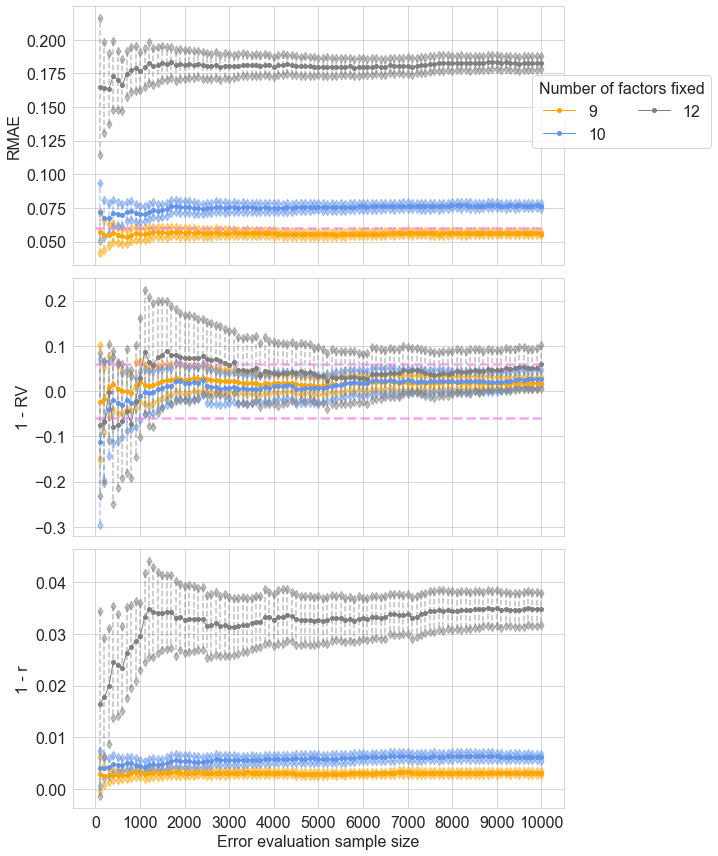

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

xtick_locator = 1000; legd_loc = 'upper right'
bbox_to_anchor = (0.92, 0.42)
for i in range(3):
    
    metric = [fn for fn in METRIC_NAME if not '_' in fn ][i]
    ylab = legds[i]; 
    k = 1
    mean_lab = f'{metric}'; #_mean 
    for fn in filename:
        df_plot = df[fn]
        if not (metric == 'mae'):
            df_plot.loc[:, mean_lab] = 1 - df_plot.loc[:, mean_lab]
            df_plot.loc[:, mean_lab + '_upper'] = 1 - df_plot.loc[:, mean_lab + '_upper']
            df_plot.loc[:, mean_lab + '_lower'] = 1 - df_plot.loc[:, mean_lab + '_lower']
            ax = plot_metric_sampling(df_plot, filename, metric, mean_lab, xlab, ylab, xtick_locator, 
                                      fs, colors[k], lgd=None, ax=axes[i],legd_bbox=bbox_to_anchor, alpha=0.5, **plot_kwagrs)
        else:
            ax = plot_metric_sampling(df_plot, filename, metric, mean_lab, xlab, ylab, xtick_locator, 
                                          fs, colors[k], lgd=lgd, ax=axes[i],legd_bbox=bbox_to_anchor, alpha=0.5, **plot_kwagrs)
        k += 1

axes[0].hlines(0.06, 0, 10000, ls='--', lw=2.5, colors='violet', alpha=0.7)
axes[1].hlines(0.06, 0, 10000, ls='--', lw=2.5, colors='violet', alpha=0.7)
axes[1].hlines(-0.06, 0, 10000, ls='--',lw=2.5, colors='violet', alpha=0.7)
fig.tight_layout()
# plt.savefig(f'../output/figure/boots_mc_all_metrics.png', format = 'png', dpi = 400)

In [ ]:
# convert the standard error of replicates into standard deviation 
filename = ['fix_6', 'fix_9', 'fix_10', 'fix_12', 'fix_17'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
fpath = '../output/morris/vertical/'
for fr in os.listdir(fpath):
    r = int(fr[1:])
    for fn in filename:
        df = pd.read_csv(f'{fpath}{fr}/{fn}/mean_estimation.csv', index_col = 'Unnamed: 0')#.iloc[0:50]
        cols = df.columns
        for col in cols[3:]:
            df.loc[:, col] = df.loc[:, col] * np.sqrt(r)
        df.to_csv(f'{fpath}{fr}/{fn}/mean_std.csv')

In [15]:
df = {}
filename = ['fix_9'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
fpath = '../output/morris/vertical/' #vertical/r20/'bootstrap_mc/
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}r20/{fn}/mean_std.csv', index_col = 'Unnamed: 0').iloc[0:30]
    df[fn].index = df[fn].index.astype('int')
    df[fn].index = (df[fn].index + 1) * 200

In [16]:
# shared properties
sns.set_style('whitegrid')
plt.rcParams['legend.title_fontsize'] = 14
colors = ['lightgreen', 'orange', 'cornflowerblue', 'gray', 'yellow']
plot_kwagrs = {'kind':'line', 'marker':'o', 'linewidth':1, 'style':'-', 'ms':4, 'logy':False}
xlab = 'Error evaluation sample size'
legds = ['RMAE', '1 - RV', '1 - r']
fs = 16; 
lgd = [fn.split('_')[1] for fn in filename]

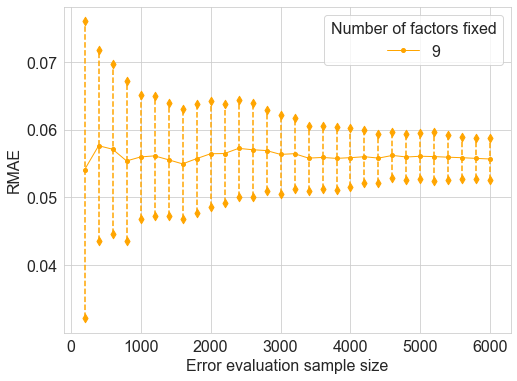

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
k = 1
metric = [fn for fn in METRIC_NAME if not '_' in fn ][0]
ylab = legds[0];
for ii in filename:
    df_plot = df[ii]
    mean_lab = f'{metric}_mean';
    xtick_locator = 1000; legd_loc = 'lower right' #'upper right'bbox_to_anchor=(0.65, 0.15)
    ax = plot_metric_sampling(df_plot, filename, metric, mean_lab, xlab, ylab, xtick_locator, fs, colors[k], 
                              lgd=lgd, ax=axes, legd_loc = 'upper right', **plot_kwagrs)
    k += 1
    
#     plot_metric_sampling(df_plot, filename, metric, mean_lab, xlab, ylab, xtick_locator, 
#                               fs, colors[k], lgd=lgd, ax=axes,legd_bbox=bbox_to_anchor, **plot_kwagrs)
plt.savefig(f'../output/figure/adaptive_replicate20_{metric}.png', format = 'png', dpi = 400)

## Plot Figure 7 

In [19]:
from settings import *
df = {}
filename = ['fix_6', 'fix_9', 'fix_10', 'fix_12', 'fix_17']
fpath = '../output/morris/bootstrap_mc/'
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}/mean_ci.csv', index_col = 'Unnamed: 0').iloc[9]
df_metric = pd.DataFrame.from_dict(df, orient = 'index')
new_index = [ind.split('_')[1] for ind in list(df_metric.index)]
df_metric.index = new_index
# df_metric

In [20]:
# obtain relative bias    
cols = df_metric.columns
df_metric.fillna(value=0.0, inplace=True)
# drop the first row due to RMAE > 0.40
cols = df_metric.columns
# yerror = [df_metric.loc[:, col].values for col in cols[-3:]]
yerror = df_metric.loc[:, cols[-3:]].values.T - df_metric.loc[:, cols[0:3]].values.T
df_metric['ppmc'] = df_metric['ppmc'].apply(lambda x: 1 - x)
df_metric['var'] = df_metric['var'].apply(lambda x: np.abs(1 - x))

x = df_metric.index
# df_metric.index = ([str(21 - i) for i in x])


In [21]:
# import the analytic variance 
fvariance = np.loadtxt('../data/variance_frac.txt')
# total_variance = 2.755
index_fix = np.array([[20, 17, 19, 15, 16, 18], [14, 12, 13], 
                    [11], [9, 10], [8, 7, 6, 5, 4], [2, 3, 0, 1]])
variance_frac = fvariance[[len(list(flatten(index_fix[0:i+1])))-1 for i in range(index_fix.size-1)]] / 100
variance_frac = np.append(variance_frac, fvariance[-1])
variance_frac = variance_frac[[0, 1, 2, 3, 4]]

<ipython-input-21-4dfac9fd093d>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  index_fix = np.array([[20, 17, 19, 15, 16, 18], [14, 12, 13],


<Figure size 432x360 with 0 Axes>

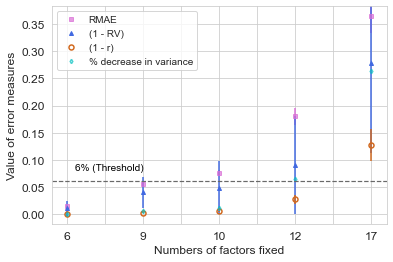

In [22]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(6, 5))
# form x label
num_in_groups = []
conf_names = [col for col in METRIC_NAME if '_conf' in col]
colors = ['orchid', 'royalblue','chocolate']
ax = df_metric[cols[:3]].plot(kind='line', yerr=yerror, linestyle='', color=colors)

x = df_metric.index
x_ticklabels = ['{}{}{}{}'.format(i, ' (', x[i], ')') for i in range(len(x))]

ax.plot(x, df_metric[METRIC_NAME[0]], 's', color=colors[0], ms=4, alpha=0.7, label='RMAE')
ax.plot(x, df_metric[METRIC_NAME[1]], '^', color=colors[1], ms=4, label='RV')
ax.plot(x, df_metric[METRIC_NAME[2]], 'o', ms=5, markerfacecolor='none',label='PPMC',
        markeredgecolor=colors[2], markeredgewidth=1.5)
          
ax.plot(x, variance_frac, 'd', ms=3, markerfacecolor='none',label='First-order variance',
        markeredgecolor='c', markeredgewidth=1.5, alpha=0.7)            
                                                                  
ax.axhline(y=0.06, xmin=0, xmax=6, linestyle='--', linewidth=1.2, color='dimgrey')
ax.tick_params(axis='both', labelsize=12)

ax.set_xlabel('Numbers of factors fixed', fontsize=12)
ax.set_ylabel('Value of error measures', fontsize=12)
# ax.set_ylim(-0.03, 0.5)
# ax.set_xlim(0.85, 7.15)

ax.legend(['RMAE', '(1 - RV)', '(1 - r)', '% decrease in variance'], loc='upper left', fontsize=10)
ax.text(0.1, 0.08, '6% (Threshold)', fontsize=10, color='k')
plt.savefig('{}{}{}'.format('../output/figure/', 'fig7_variance', '.png'), dpi=300, format='png')

## Plot Figure 8

In [27]:
path = '../output/morris/bootstrap_mc/'
f_default = np.append([0, 0.1, 0.4, 0.5], np.linspace(0.2, 0.3, 11))
f_default.sort()
f_default = [round(i, 2) for i in f_default]
# f_default[0] = '0.00'

In [28]:
#prepare data for plotting
for fn in f_default:
    try: 
        group1.loc[fn, :] = pd.read_csv(f'{path}{fn}/fix_6/replicate0.csv', index_col = 'Unnamed: 0').values
    except NameError:
        group1 = pd.read_csv(f'{path}{fn}/fix_6/replicate0.csv', index_col = 'Unnamed: 0')
        group1.index = fn
        
for fn in f_default:
    try: 
        group2.loc[fn, :] = pd.read_csv(f'{path}{fn}/fix_9/replicate0.csv', index_col = 'Unnamed: 0').values
    except NameError:
        group2 = pd.read_csv(f'{path}{fn}/fix_9/replicate0.csv', index_col = 'Unnamed: 0')
        group2.index = fn   

cols = group1.columns
for i in range(len(cols[0:3])):
    group1.loc[:, cols[i+3]] = group1.loc[:, cols[i]] - 1.96 * (group1.loc[:, cols[i]] - group1.loc[:, cols[i+3]])
    group1.loc[:, cols[i+6]] = group1.loc[:, cols[i]] + 1.96 * (group1.loc[:, cols[i+6]] - group1.loc[:, cols[i]])
    
for i in range(len(cols[0:3])):
    group2.loc[:, cols[i+3]] = group2.loc[:, cols[i]] - 1.96 * (group2.loc[:, cols[i]] - group2.loc[:, cols[i+3]])
    group2.loc[:, cols[i+6]] = group2.loc[:, cols[i]] + 1.96 * (group2.loc[:, cols[i+6]] - group2.loc[:, cols[i]])

C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting

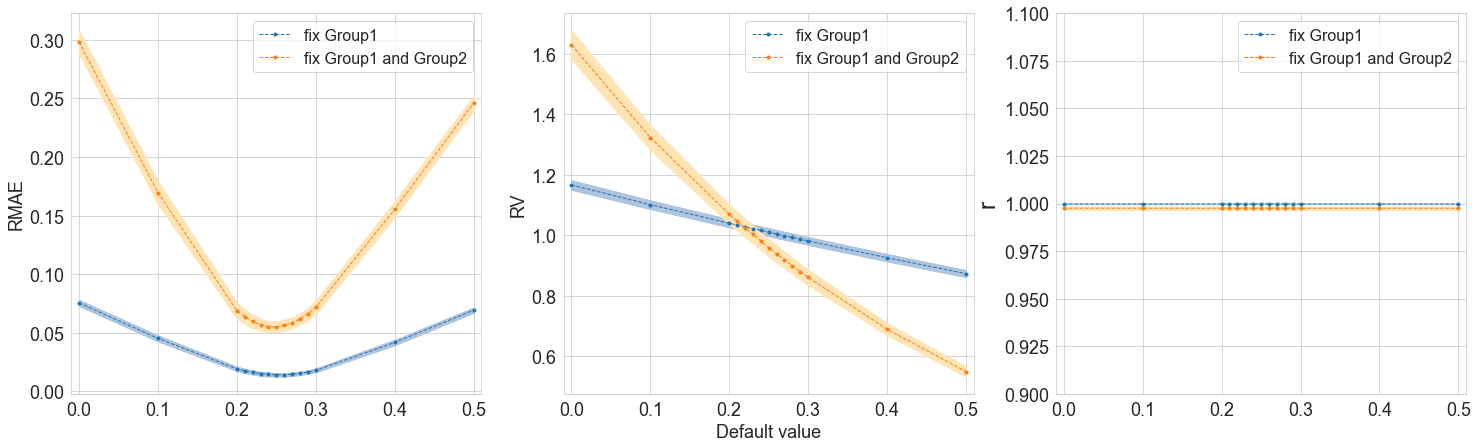

In [29]:
def plot_shadow(df, col_name, ax, ylabel, color, ylim=None, fs=None):
    df.loc[:, col_name].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax=ax)
    ax.fill_between(df.index, df[f'{col_name}_lower'], df[f'{col_name}_upper'], color=color)
    ax.fill_between(df.index, df[f'{col_name}_lower'], df[f'{col_name}_upper'], color=color)
    ax.set_xlim(-0.01, 0.51)
    if not (ylim==None):
        ax.set_ylim(ylim[0], ylim[1])
    ax.tick_params(axis='both', which='major', labelsize=18)
    if fs == None:
        ax.set_ylabel(ylabel, fontsize=18)
    else:
        ax.set_ylabel(ylabel, fontsize=24)    
    ax.legend(['fix Group1', 'fix Group1 and Group2'], fontsize=16)
# End plot_shadow()

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
colors = ['lightsteelblue', 'moccasin']
k = 0
for df in [group1, group2]:
    color = colors[k]
    plot_shadow(df, 'mae', axes[0], 'RMAE', color)
    plot_shadow(df, 'var', axes[1], 'RV', color)
#     fig.suptitle('Morris (n=80)', fontsize=20)
    axes[1].set_xlabel('Default value',  fontsize=18)
    plot_shadow(df, 'ppmc', axes[2], 'r', color, [0.9, 1.1], 26)
    k += 1

plt.savefig(f'../output/figure/fig8_evaluate_defaults.png', format='png', dpi=300)
